In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)


def run_rf(X, Y):
    results = np.zeros((Y.shape[1], X.shape[1]))
    for i in range(Y.shape[1]):
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, Y[:, i])
        results[i] = model.feature_importances_
    return results

def run_lasso(X_scaled, Y):
    results = np.zeros((Y.shape[1], X_scaled.shape[1]))
    for i in range(Y.shape[1]):
        model = LassoCV(cv=5, random_state=42, max_iter=10000)
        model.fit(X_scaled, Y[:, i])
        results[i] = np.abs(model.coef_)
    return results


def run_nn(X_scaled, Y):
    results = np.zeros((Y.shape[1], X_scaled.shape[1]))
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    for i in range(Y.shape[1]):
        y = (Y[:, i] - np.mean(Y[:, i])) / (np.std(Y[:, i]) + 1e-8)
        y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
        loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=8, shuffle=True)

        model = NeuralNet(input_dim=X_scaled.shape[1])
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
        criterion = nn.MSELoss()

        model.train()
        for _ in range(200):
            for xb, yb in loader:
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()

        with torch.no_grad():
            results[i] = model.fc1.weight.abs().mean(dim=0).numpy()
    return results

def run_hybrid(results_dict):
    hybrid = np.zeros_like(results_dict["rf"])
    for model_name in results_dict:
        scores = results_dict[model_name]
        norm_scores = scores / (np.linalg.norm(scores, axis=1, keepdims=True) + 1e-8)
        hybrid += norm_scores
    return hybrid / len(results_dict)


In [ ]:
def save_model_outputs(results_dict, hybrid, folder_name, tf_names, gene_names):
    for model_name, scores in results_dict.items():
        df = pd.DataFrame(scores, index=gene_names, columns=tf_names)
        df.to_csv(f"{folder_name}/{model_name}_importance.csv")
    hybrid_df = pd.DataFrame(hybrid, index=gene_names, columns=tf_names)
    hybrid_df.to_csv(f"{folder_name}/hybrid_importance.csv")
    

def compute_auroc_curve(pred_df, ground_truth_set, model_name):
    y_true, y_scores = [], []
    for gene in pred_df.index:
        target_id = int(gene.split("_")[1])
        for tf in pred_df.columns:
            tf_id = int(tf.split("_")[1])
            y_scores.append(pred_df.loc[gene, tf])
            y_true.append((tf_id, target_id) in ground_truth_set)
    y_true = [1 if x else 0 for x in y_true]
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    return fpr, tpr, auc, model_name


def compute_genewise_auroc(df, ground_truth_set, model_name):
    scores = []
    for gene in df.index:
        target_id = int(gene.split("_")[1])
        y_true, y_scores = [], []
        for tf in df.columns:
            tf_id = int(tf.split("_")[1])
            y_scores.append(df.loc[gene, tf])
            y_true.append((tf_id, target_id) in ground_truth_set)
        if len(set(y_true)) < 2:
            continue
        auc = roc_auc_score(y_true, y_scores)
        scores.append({"TargetGene": target_id, f"AUROC_{model_name}": auc})
    return pd.DataFrame(scores)




def plot_auroc_curves(model_dfs, ground_truth_set, folder_name):
    plt.figure(figsize=(10, 8))
    for df, name in model_dfs:
        fpr, tpr, auc, label = compute_auroc_curve(df, ground_truth_set, name)
        plt.plot(fpr, tpr, label=f"{label} (AUROC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC Curves for GRN Reconstruction Models")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{folder_name}/auroc_curve.png")
    plt.show()

def plot_pr_curves(model_dfs, ground_truth_set, folder_name):
    plt.figure(figsize=(10, 8))

    for df, name in model_dfs:
        y_true, y_scores = [], []

        for gene in df.index:
            target_id = int(gene.split("_")[1])
            for tf in df.columns:
                tf_id = int(tf.split("_")[1])
                score = df.loc[gene, tf]
                y_scores.append(score)
                y_true.append((tf_id, target_id) in ground_truth_set)

        y_true = [1 if x else 0 for x in y_true]

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = average_precision_score(y_true, y_scores)

        plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.3f})")

    baseline = sum(y_true) / len(y_true)
    plt.hlines(baseline, 0, 1, colors='k', linestyles='--', label="Random Classifier")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves for GRN Reconstruction Models")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{folder_name}/pr_curve.png")
    plt.show()


def evaluate_models(model_dfs, ground_truth_set, baseline_df, folder_name):
    all_auc_dfs = []

    for df, name in model_dfs:
        model_key = name.lower().replace(" ", "_")
        auc_df = compute_genewise_auroc(df, ground_truth_set, model_key)
        all_auc_dfs.append(auc_df)


    merged = baseline_df.copy()
    for df in all_auc_dfs:
        merged = merged.merge(df, on="TargetGene")

    model_keys = [name.lower().replace(" ", "_") for _, name in model_dfs]

    # --- Scatter plots (AUROC) ---
    for key in model_keys:
        plt.figure(figsize=(7, 6))
        plt.scatter(merged["AUROC_baseline"], merged[f"AUROC_{key}"])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("Baseline AUROC")
        plt.ylabel(f"{key.upper()} AUROC")
        plt.title(f"Baseline vs {key.upper()} AUROC (per target gene)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{folder_name}/{key}_auroc_scatter.png")
        plt.show()


    # --- Combined Scatter Plot for All Models ---
    model_colors = {
        "random_forest": "tab:blue",
        "lasso": "tab:orange",
        "neural_network": "tab:green"
    }

    plt.figure(figsize=(8, 7))

    for key in model_keys:
        plt.scatter(
            merged["AUROC_baseline"],
            merged[f"AUROC_{key}"],
            alpha=0.6,
            label=key.replace("_", " ").title(),
            color=model_colors.get(key, "gray")
        )

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label="y = x")
    plt.xlabel("Baseline AUROC", fontsize=12)
    plt.ylabel("Model AUROC", fontsize=12)
    plt.title("Baseline vs Model AUROC (Per Target Gene)", fontsize=14, fontweight='bold')
    plt.legend(title="Model", loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{folder_name}/combined_auroc_scatter.png")
    plt.show()

 

    # --- Violin plot for AUROC ---
    method_order = ["Baseline", "RANDOM_FOREST", "LASSO", "NEURAL_NETWORK", "HYBRID"]
    method_colors = {
        "Baseline": "gray",
        "RANDOM_FOREST": "tab:blue",
        "LASSO": "tab:orange",
        "NEURAL_NETWORK": "tab:green",
        "HYBRID": "tab:purple"
    }

    # Build DataFrame
    auroc_plot_data = pd.DataFrame({
        "AUROC": pd.concat(
            [merged["AUROC_baseline"]] + [merged[f"AUROC_{key}"] for key in model_keys] + [merged["AUROC_hybrid"]],
            ignore_index=True
        ),
        "Method": (
            ["Baseline"] * len(merged) +
            sum([[key.upper()] * len(merged) for key in model_keys], []) +
            ["HYBRID"] * len(merged)
        )
    })

    # Plot
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.violinplot(
        x="Method",
        y="AUROC",
        data=auroc_plot_data,
        order=method_order,
        palette=[method_colors[m] for m in method_order],
        linewidth=1
    )

    plt.title("AUROC Distribution per Method", fontsize=14, fontweight="bold", pad=12)
    plt.xlabel("")
    plt.ylabel("AUROC", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.5)

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig(f"{folder_name}/auroc_violin.png")
    plt.show()


    # --- T-tests for AUROC & PR AUC ---
    for key in model_keys:
        auc_stat, auc_p = ttest_ind(merged["AUROC_baseline"], merged[f"AUROC_{key}"])
        print(f"\n{key.upper()} vs Baseline:")
        baseline = merged["AUROC_baseline"]

        
        print(f"  AUROC   - T: {auc_stat:.2f}, P: {auc_p:.2e}, Mean: {merged[f'AUROC_{key}'].mean():.3f}")
        print(f"Average AUROC - Baseline: {baseline.mean():.3f}")
    
    return merged

def plot_all_auroc_deltas(merged_df, folder_name):
    model_keys = ["random_forest", "lasso", "neural_network"]
    colors = {
        "random_forest": "tab:blue",
        "lasso": "tab:orange",
        "neural_network": "tab:green"
    }

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    for model_key in model_keys:
        delta = merged_df["AUROC_hybrid"] - merged_df[f"AUROC_{model_key}"]
        plt.hist(
            delta,
            bins=30,
            alpha=0.5,
            label=f"Hybrid - {model_key.replace('_', ' ').title()}",
            color=colors[model_key],
            edgecolor=None  
        )

 
    plt.axvline(0, color='red', linestyle='--', linewidth=1, label="No Improvement")


    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.xlabel("Δ AUROC (Hybrid - Model)", fontsize=12)
    plt.ylabel("Number of Target Genes", fontsize=12)
    plt.title("Distribution of AUROC Improvements (Hybrid over Models)", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{folder_name}/delta_auroc_overlay.png")
    plt.show()




def plot_top_gene_improvements_subplots(merged_df, folder_name, top_n=5):
    model_keys = ["random_forest", "lasso", "neural_network"]
    model_names = ["Random Forest", "Lasso", "Neural Network"]
    colors = sns.color_palette("tab10")  

    plt.ioff()  

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

    for idx in range(3):
        model_key = model_keys[idx]
        model_name = model_names[idx]

        
        delta = merged_df[["TargetGene", f"AUROC_hybrid", f"AUROC_{model_key}"]].copy()
        delta["improvement"] = delta["AUROC_hybrid"] - delta[f"AUROC_{model_key}"]
        delta = delta.sort_values("improvement", ascending=False).head(top_n)

        
        ordered_genes = delta.sort_values("improvement", ascending=False)["TargetGene"]

        # Plot
        sns.barplot(
            ax=axes[idx],
            data=delta,
            x="TargetGene",
            y="improvement",
            order=ordered_genes,
            hue="TargetGene",
            palette={gene: colors[idx] for gene in delta["TargetGene"]},
            legend=False
        )

        axes[idx].set_title(model_name, fontsize=14, fontweight='bold')
        axes[idx].set_xlabel("Target Gene")
        axes[idx].tick_params(axis='x', rotation=45)

        if idx == 0:
            axes[idx].set_ylabel("AUROC Improvement\n(Hybrid - Model)", fontsize=12)
        else:
            axes[idx].set_ylabel("")

    plt.suptitle(f"Top {top_n} Improved Genes per Model", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{folder_name}/top_{top_n}_improved_genes_3subplots.png")
    plt.show()


def get_top_1_gene_ids(merged_df):
    model_keys = ["random_forest", "lasso", "neural_network"]
    top_gene_ids = []

    for model_key in model_keys:
        delta = merged_df[["TargetGene", f"AUROC_hybrid", f"AUROC_{model_key}"]].copy()
        delta["improvement"] = delta["AUROC_hybrid"] - delta[f"AUROC_{model_key}"]
        delta = delta.sort_values("improvement", ascending=False)

        
        top_gene = delta.iloc[0]["TargetGene"]
        top_gene_ids.append(int(top_gene))

    return top_gene_ids

def plot_multi_gene_radar(merged_df, target_ids, folder_name):
    labels = ["Baseline", "RF", "Lasso", "NN", "Hybrid"]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]  

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    color_cycle = plt.cm.tab10.colors  

    for idx, gene_id in enumerate(target_ids):
        row = merged_df[merged_df["TargetGene"] == gene_id]
        if row.empty:
            print(f"[!] TargetGene {gene_id} not found, skipping.")
            continue

        try:
            values = [
                row["AUROC_baseline"].values[0],
                row["AUROC_random_forest"].values[0],
                row["AUROC_lasso"].values[0],
                row["AUROC_neural_network"].values[0],
                row["AUROC_hybrid"].values[0]
            ]
        except KeyError as e:
            print(f"[!] Missing column {e} for TargetGene {gene_id}, skipping.")
            continue

        if any(pd.isna(values)):
            print(f"[!] AUROC missing for gene {gene_id}, skipping.")
            continue

        values += values[:1]  
        ax.plot(angles, values, label=f"Gene {gene_id}", linewidth=2, color=color_cycle[idx % len(color_cycle)])
        ax.fill(angles, values, alpha=0.1, color=color_cycle[idx % len(color_cycle)])

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.set_title("AUROC per Model for Selected Target Genes \n ", fontsize=14, fontweight='bold', loc="center")
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.savefig(f"{folder_name}/radar_selected_genes.png")
    plt.show()


def plot_model_correlation_heatmap(merged_df, folder_name):
    model_cols = ["AUROC_baseline", "AUROC_random_forest","AUROC_lasso", "AUROC_neural_network", "AUROC_hybrid"]
    corr_matrix = merged_df[model_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    heatmap = sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        vmin=-1, vmax=1, center=0,
        linewidths=0.5,
        linecolor="black",
        square=True,
        cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"}
    )
    heatmap.set_title("AUROC Correlation Across Models", fontsize=16, pad=20)
    plt.xticks(rotation=30, ha="right", fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
    plt.savefig(f"{folder_name}/model_correlation_heatmap.png")
    plt.show()



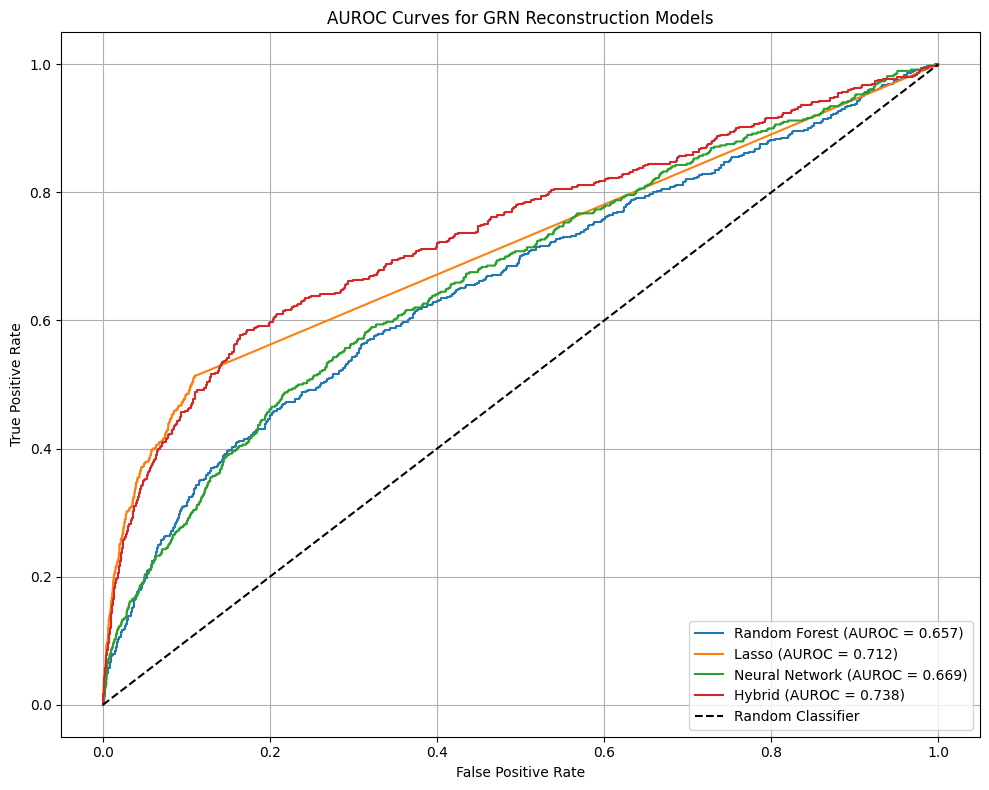

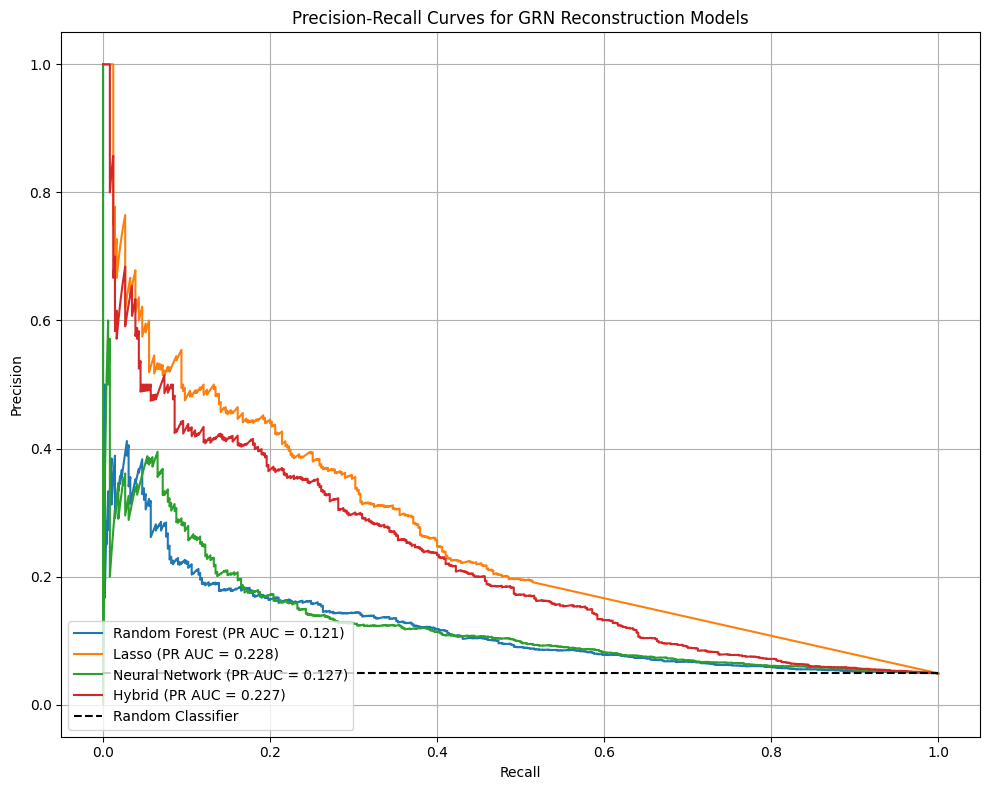

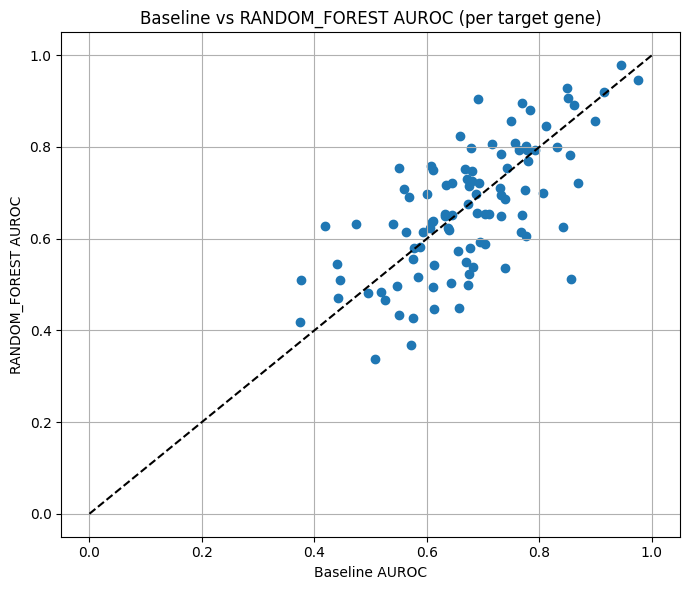

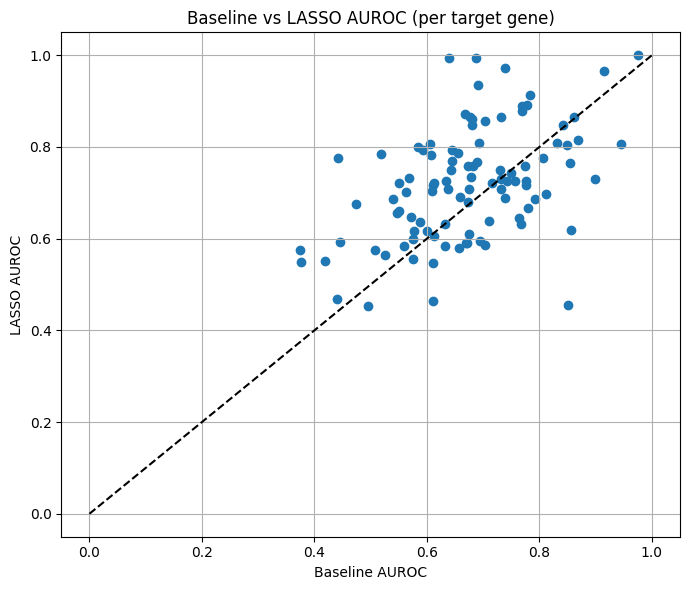

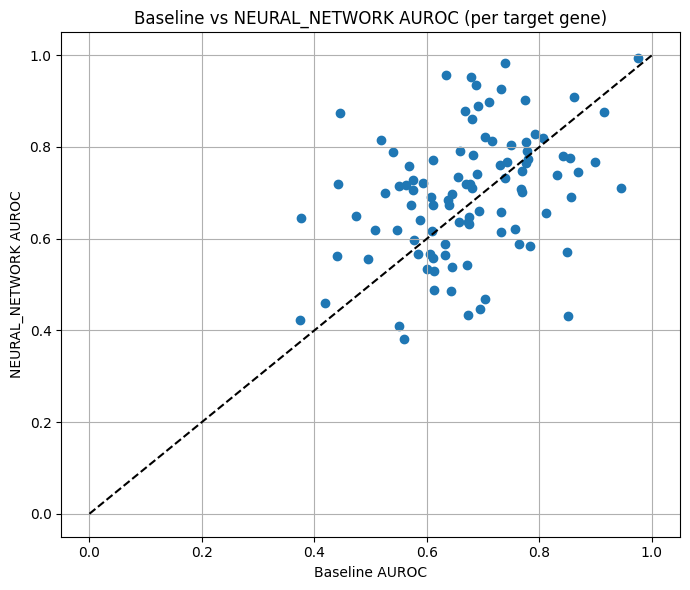

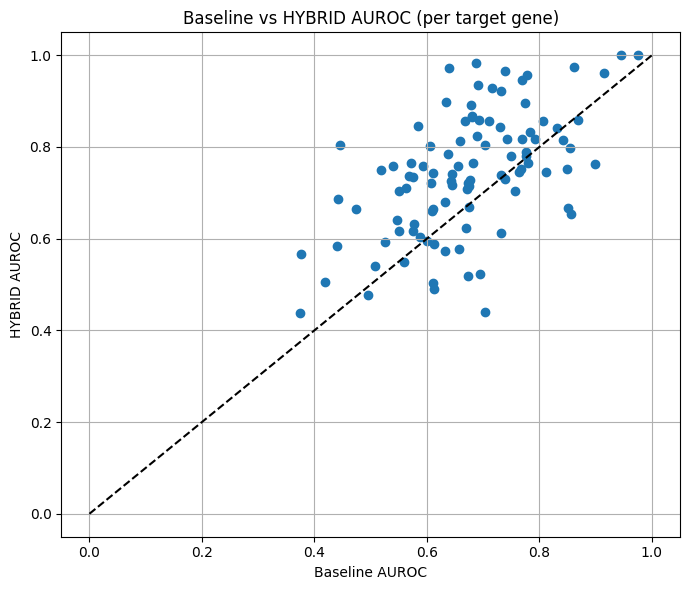

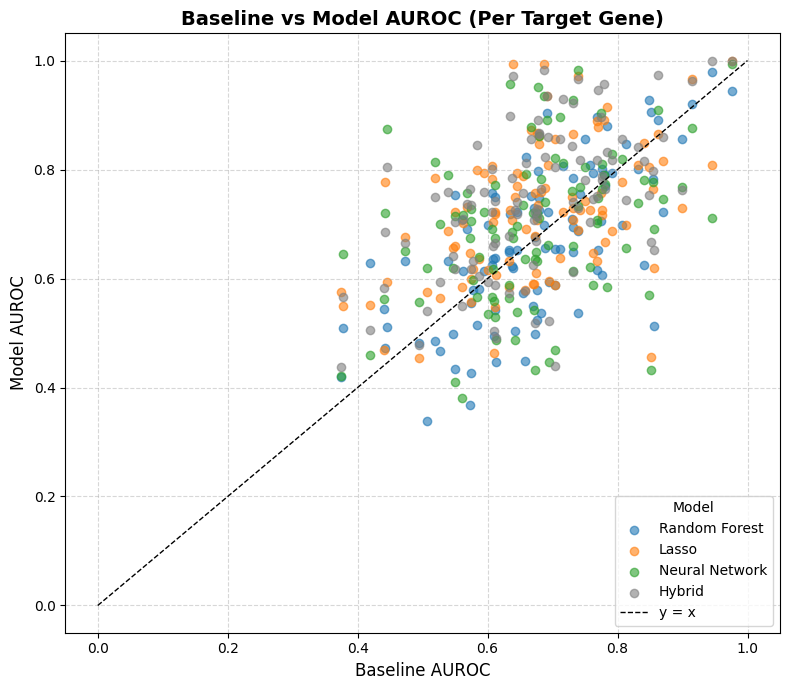

C:\Users\Shera\AppData\Local\Temp\ipykernel_40808\4007343178.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


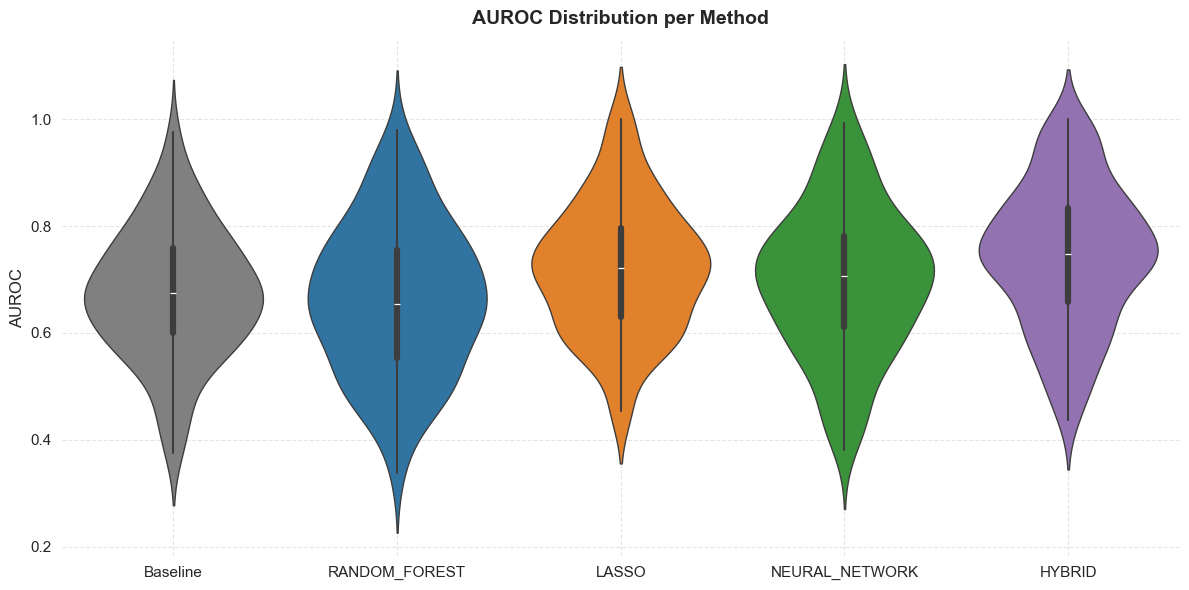


RANDOM_FOREST vs Baseline:
  AUROC   - T: 0.49, P: 6.22e-01, Mean: 0.663
Average AUROC - Baseline: 0.673

LASSO vs Baseline:
  AUROC   - T: -2.73, P: 6.84e-03, Mean: 0.720
Average AUROC - Baseline: 0.673

NEURAL_NETWORK vs Baseline:
  AUROC   - T: -1.24, P: 2.15e-01, Mean: 0.695
Average AUROC - Baseline: 0.673

HYBRID vs Baseline:
  AUROC   - T: -3.86, P: 1.56e-04, Mean: 0.743
Average AUROC - Baseline: 0.673


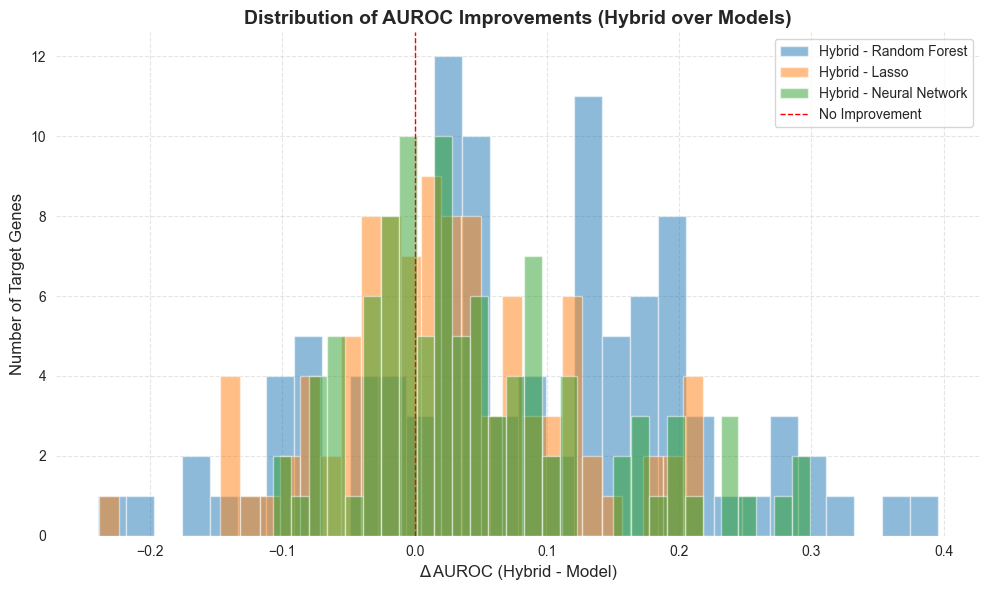

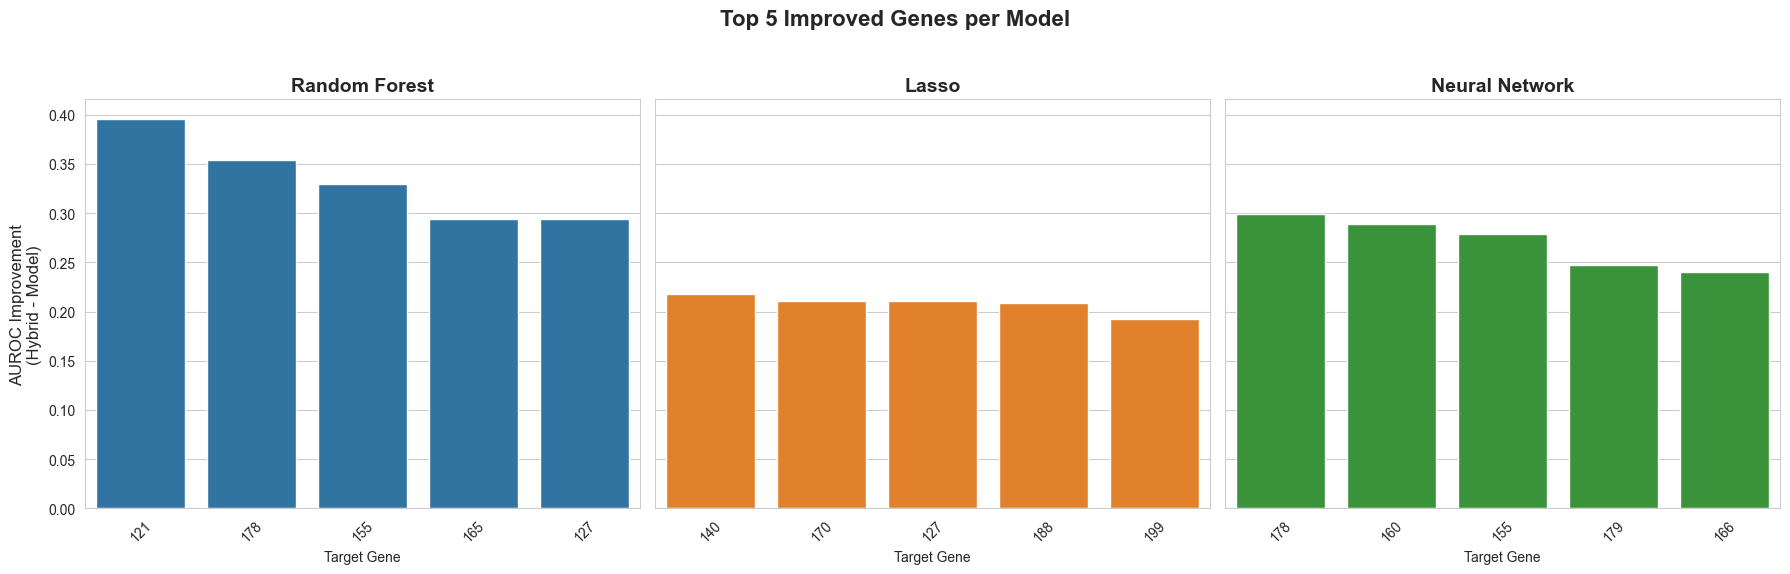

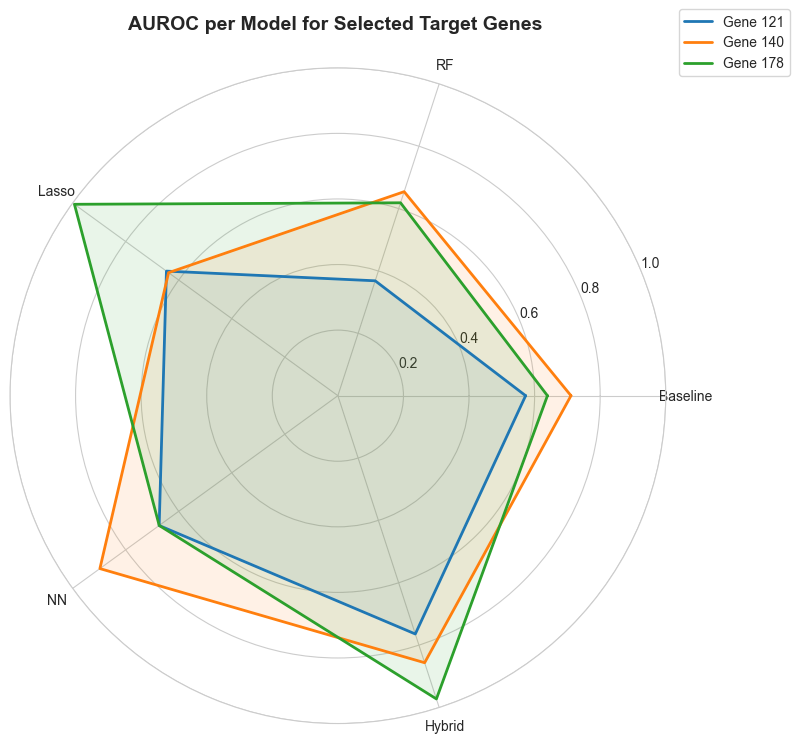

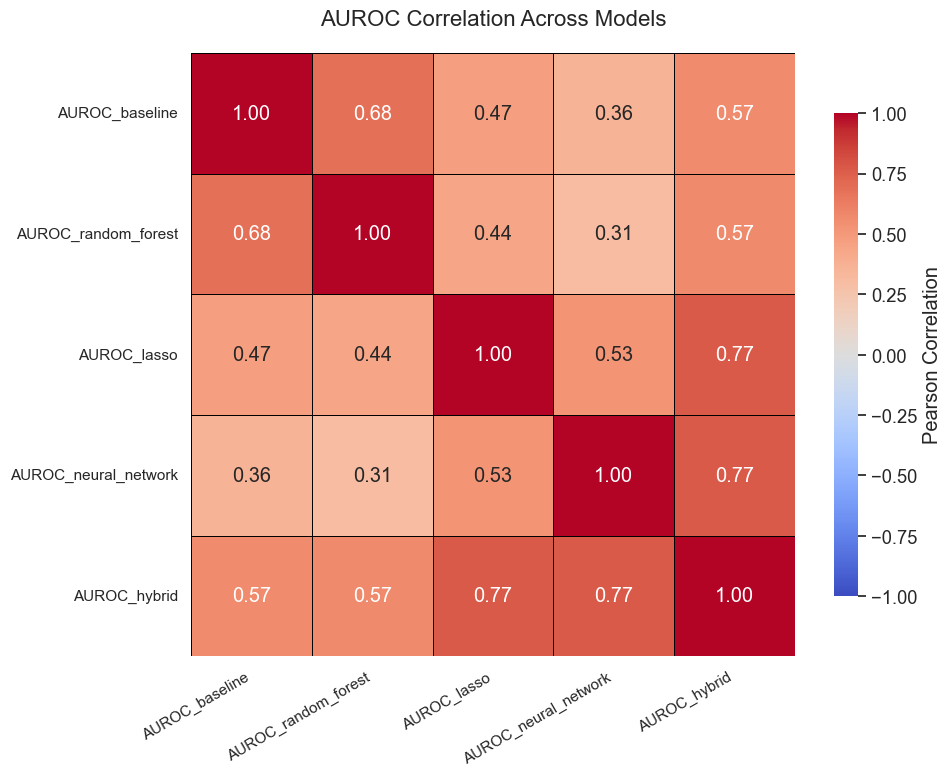

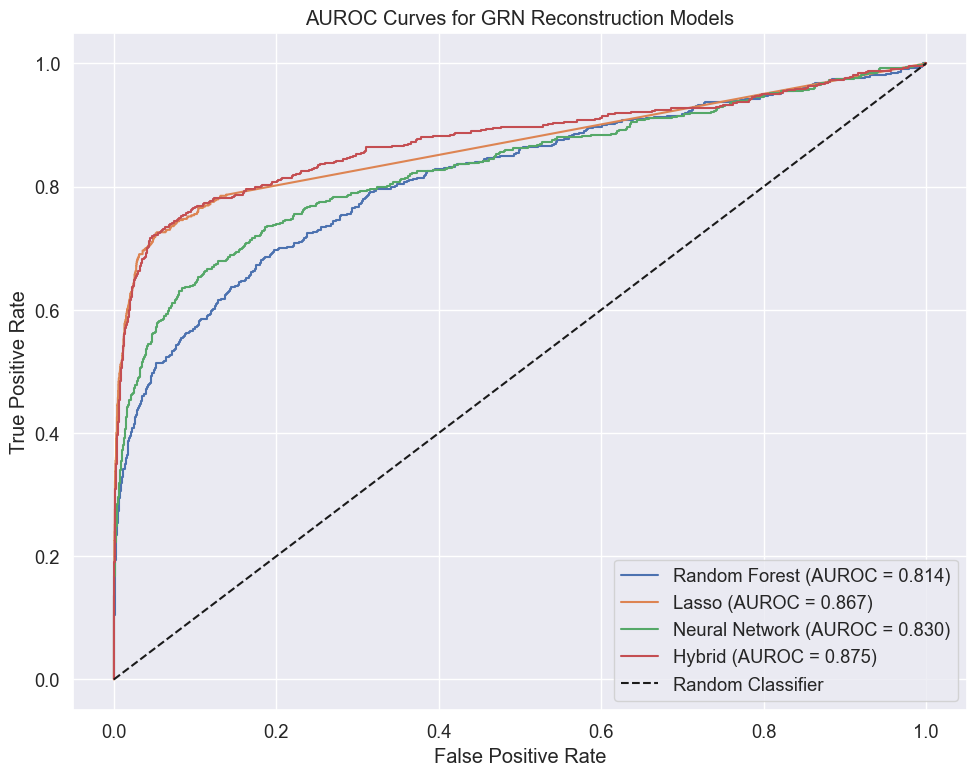

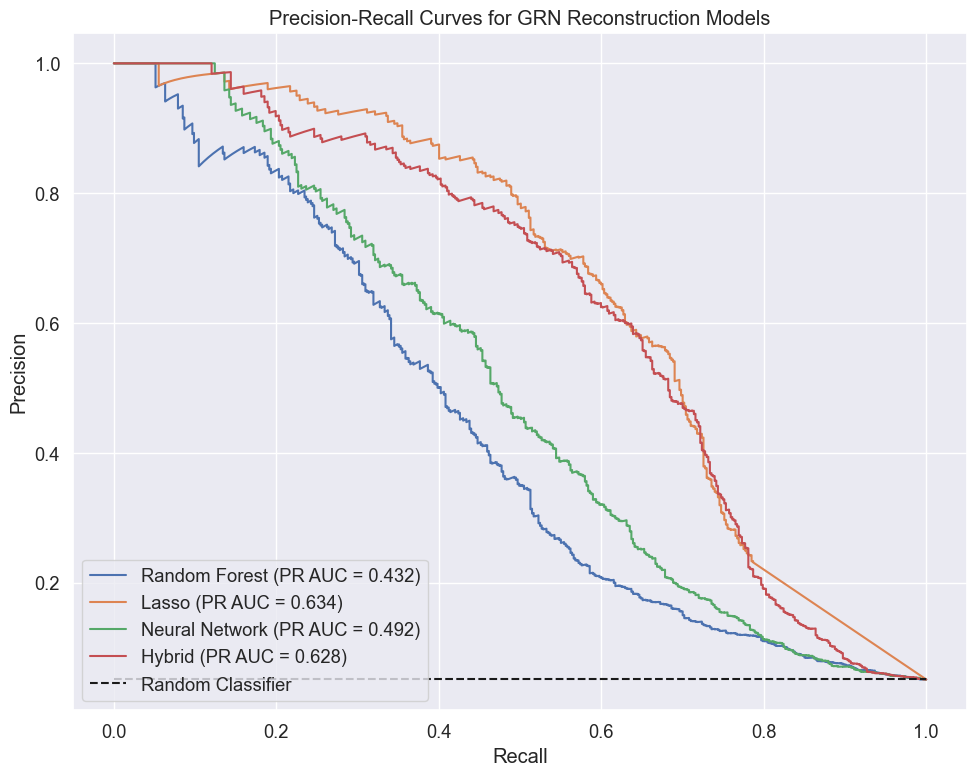

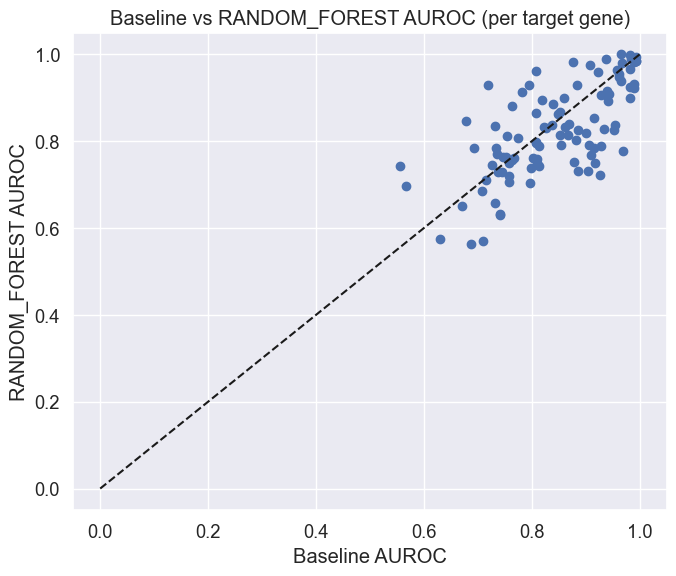

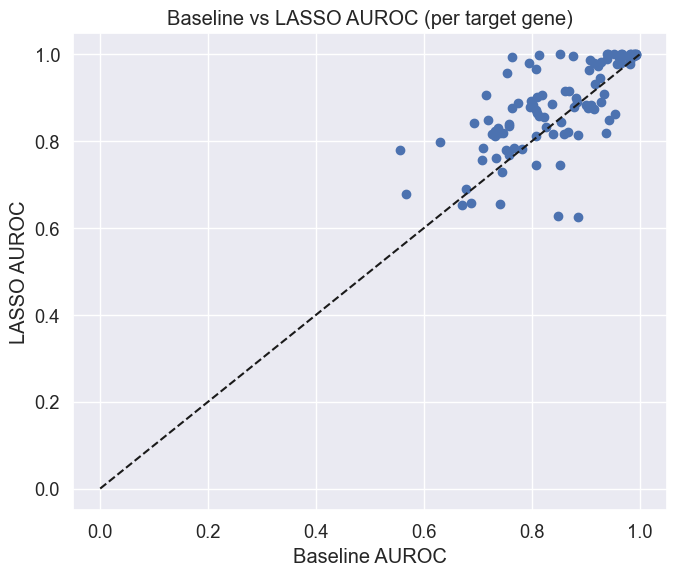

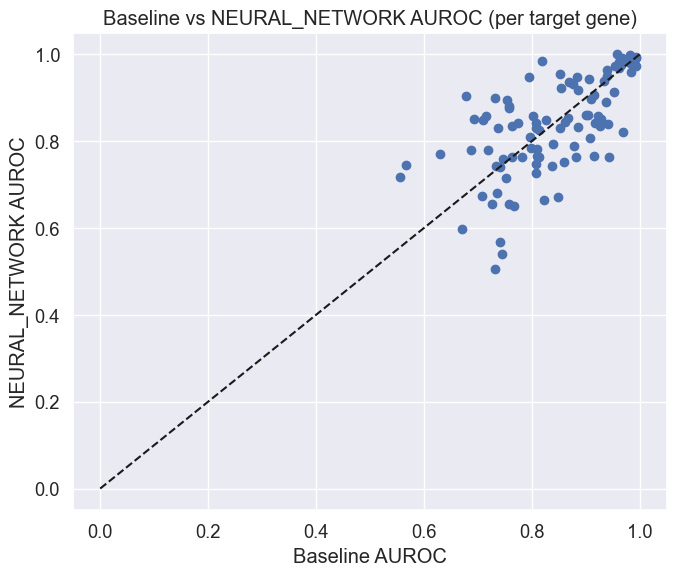

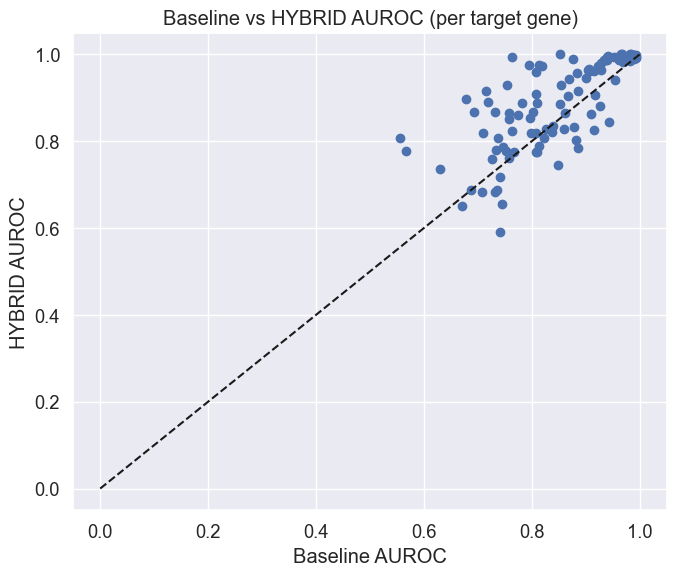

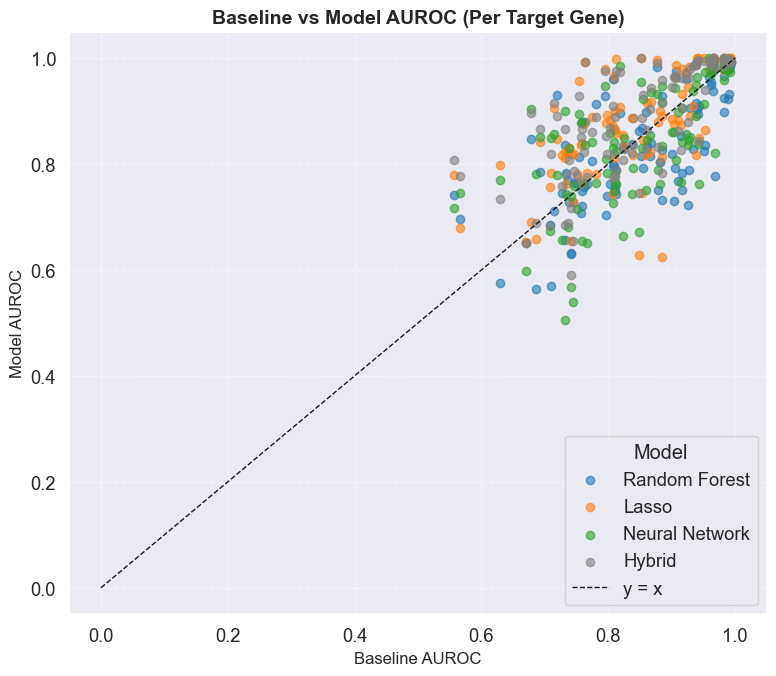

C:\Users\Shera\AppData\Local\Temp\ipykernel_40808\4007343178.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


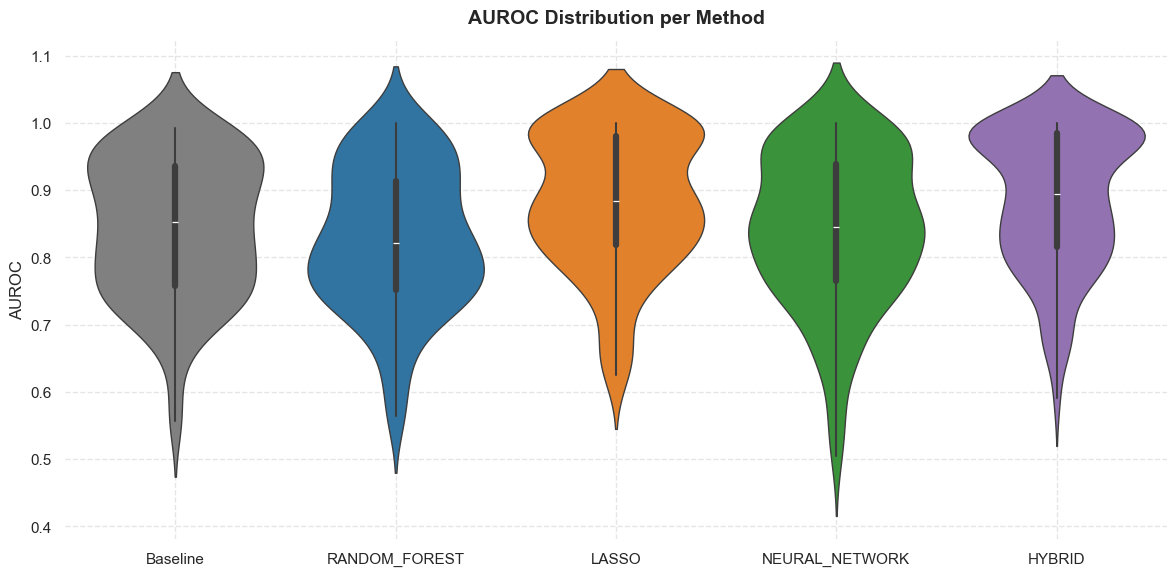


RANDOM_FOREST vs Baseline:
  AUROC   - T: 1.22, P: 2.22e-01, Mean: 0.826
Average AUROC - Baseline: 0.844

LASSO vs Baseline:
  AUROC   - T: -2.49, P: 1.35e-02, Mean: 0.880
Average AUROC - Baseline: 0.844

NEURAL_NETWORK vs Baseline:
  AUROC   - T: 0.26, P: 7.96e-01, Mean: 0.840
Average AUROC - Baseline: 0.844

HYBRID vs Baseline:
  AUROC   - T: -2.77, P: 6.15e-03, Mean: 0.884
Average AUROC - Baseline: 0.844


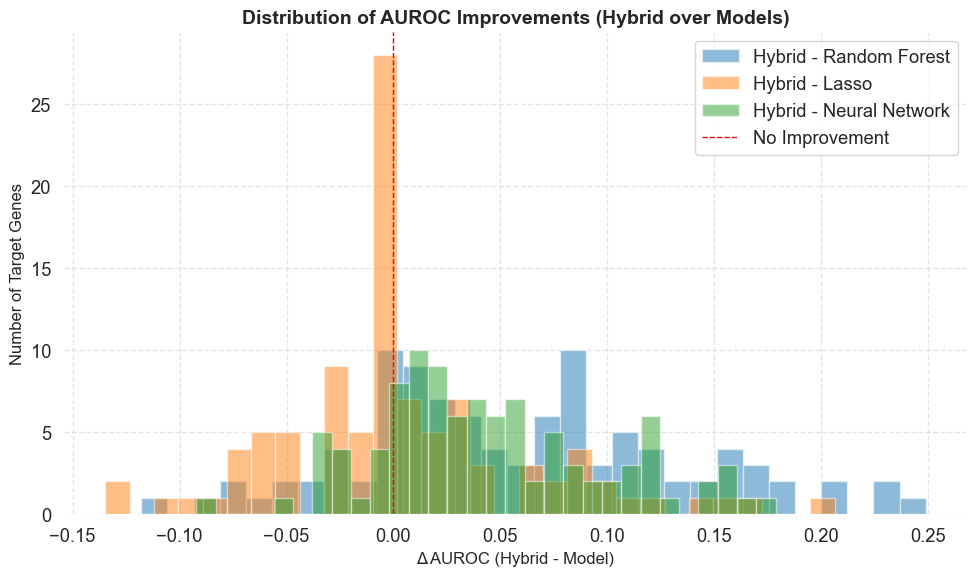

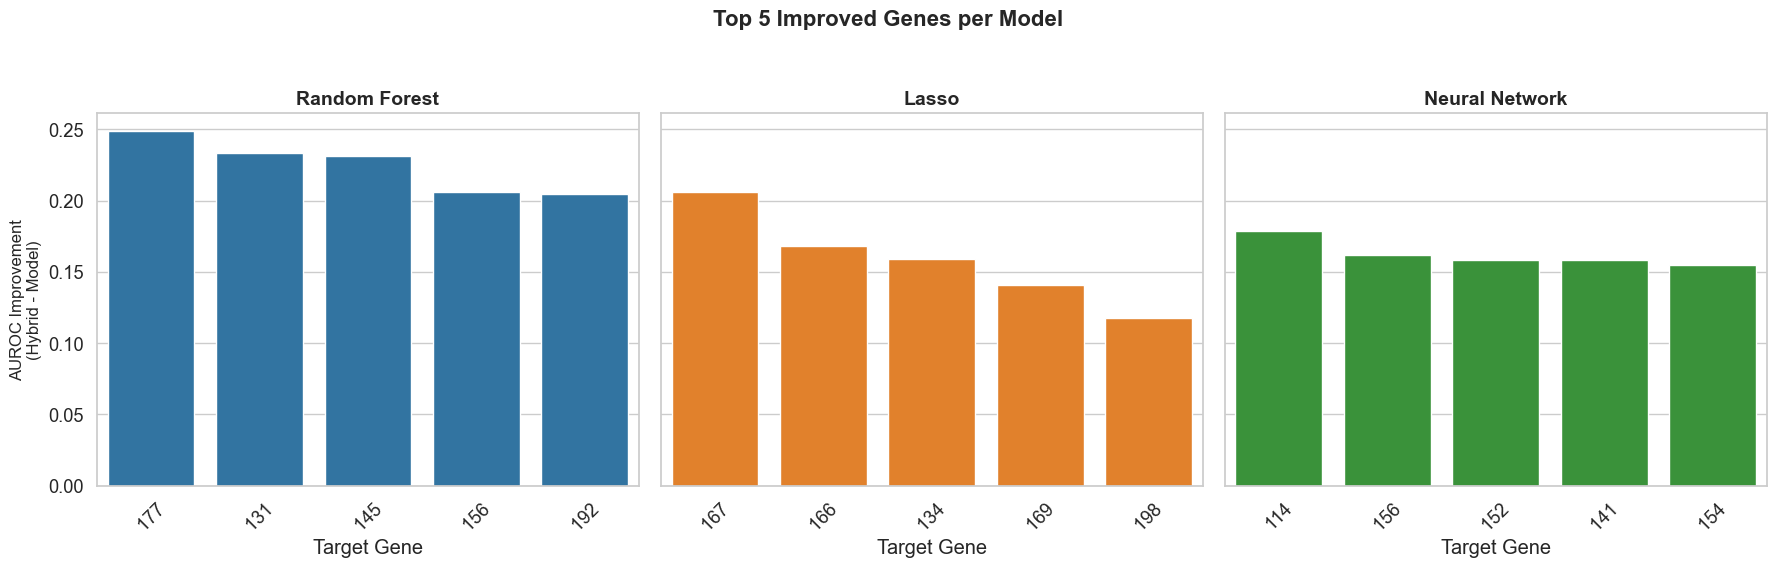

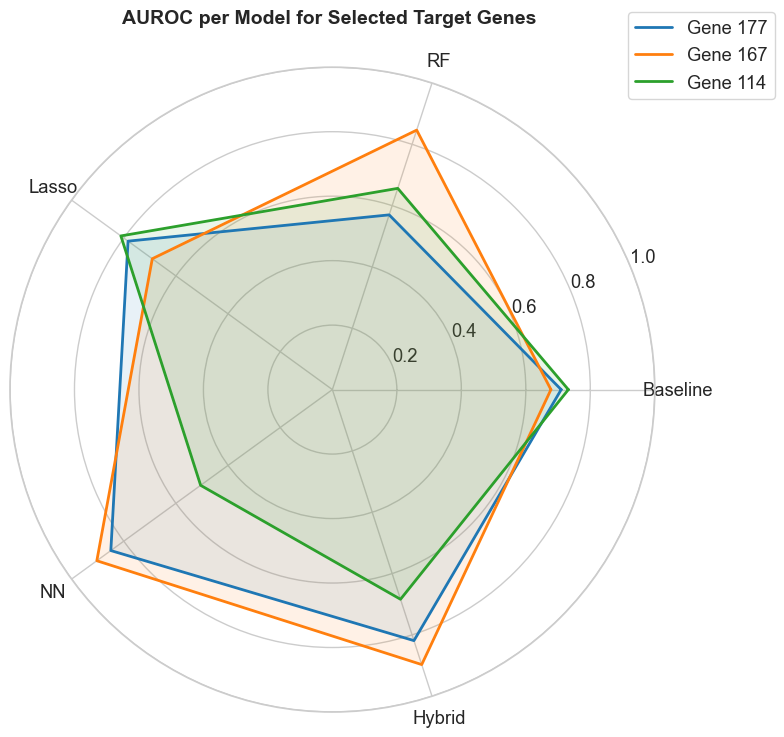

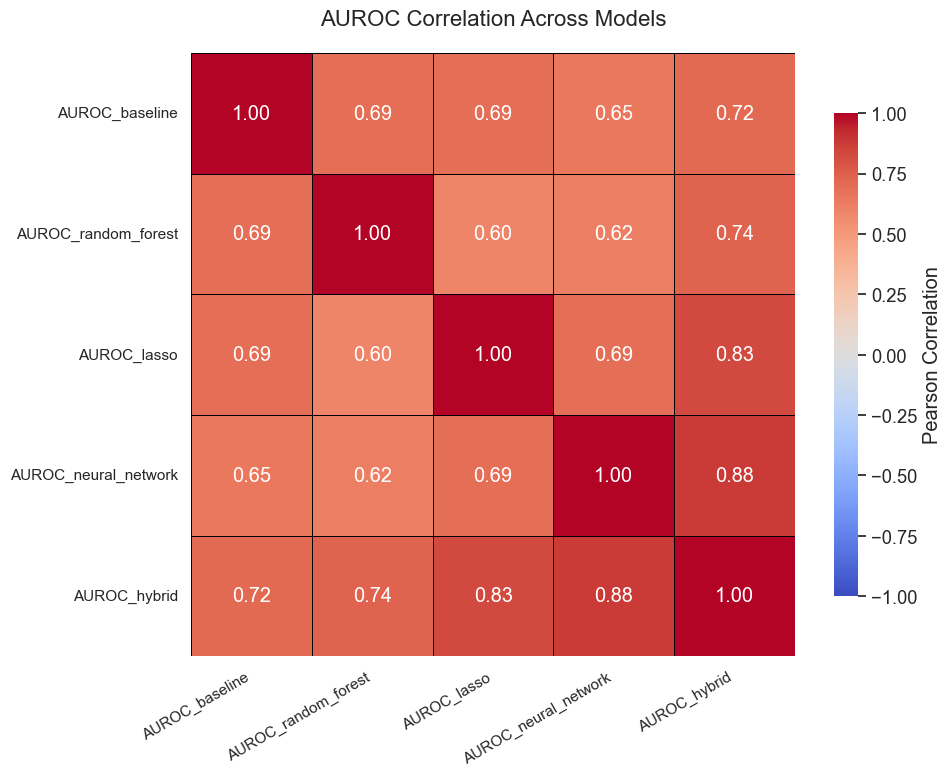

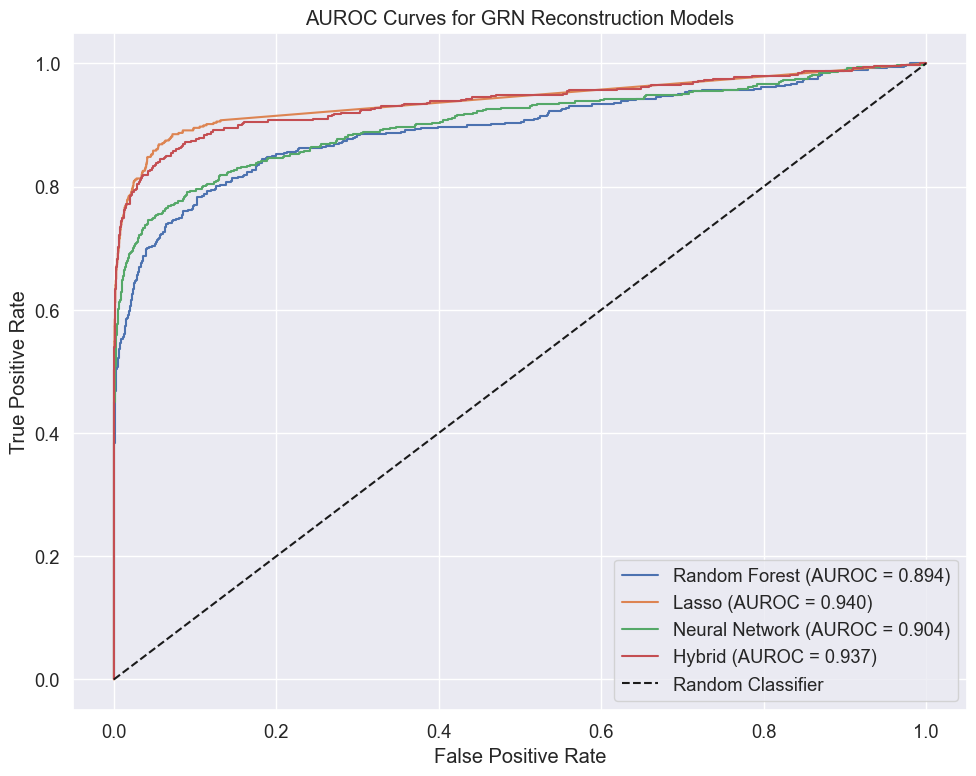

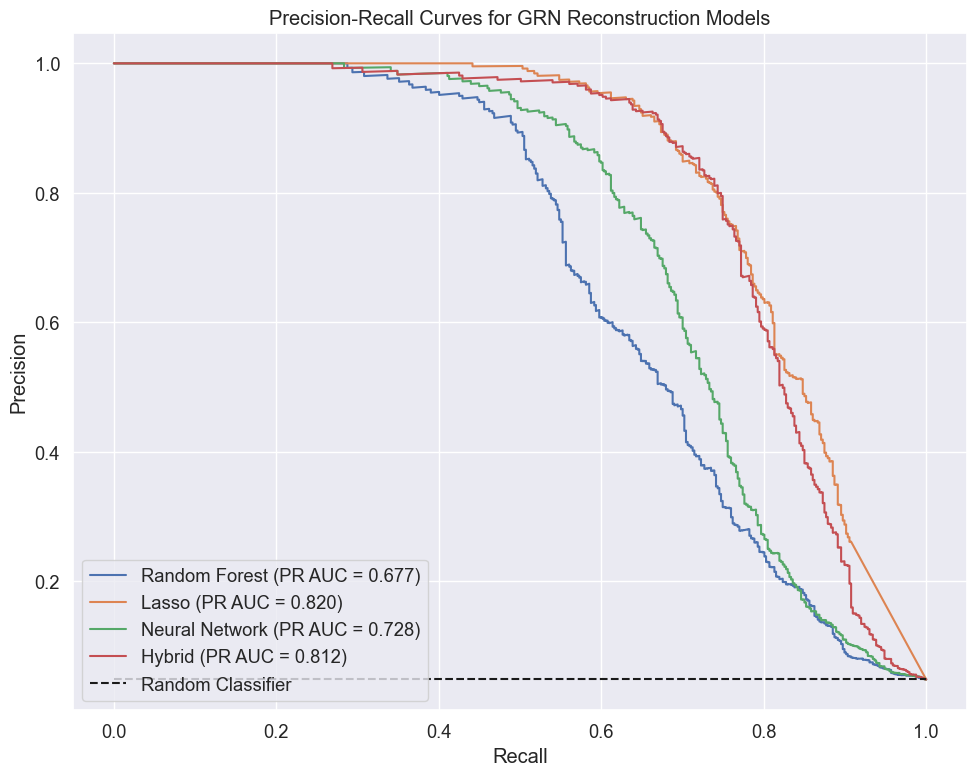

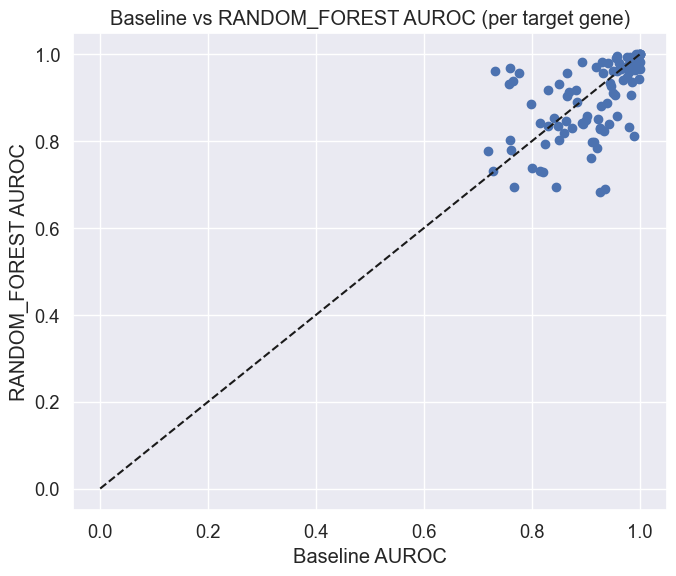

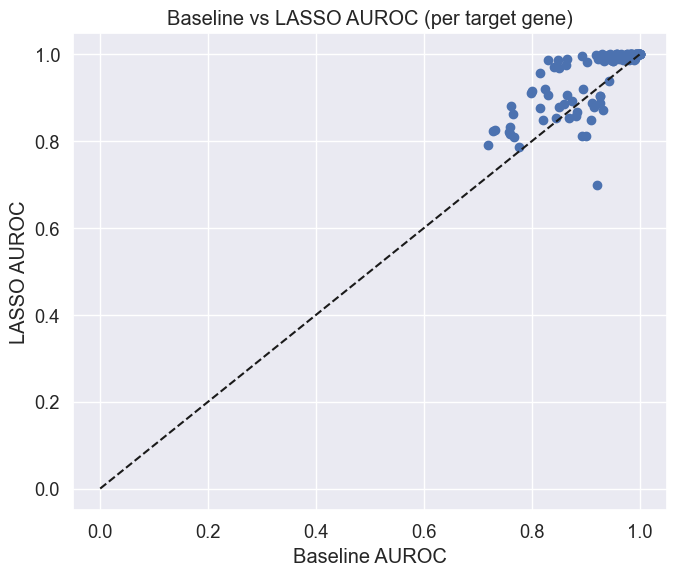

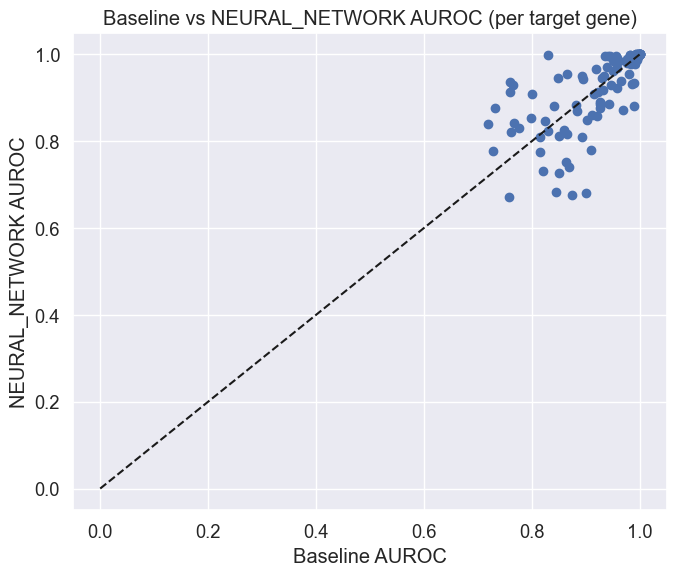

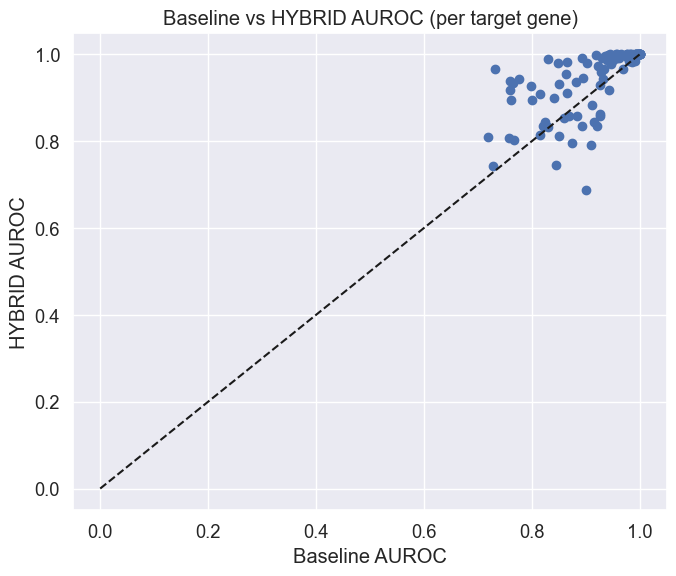

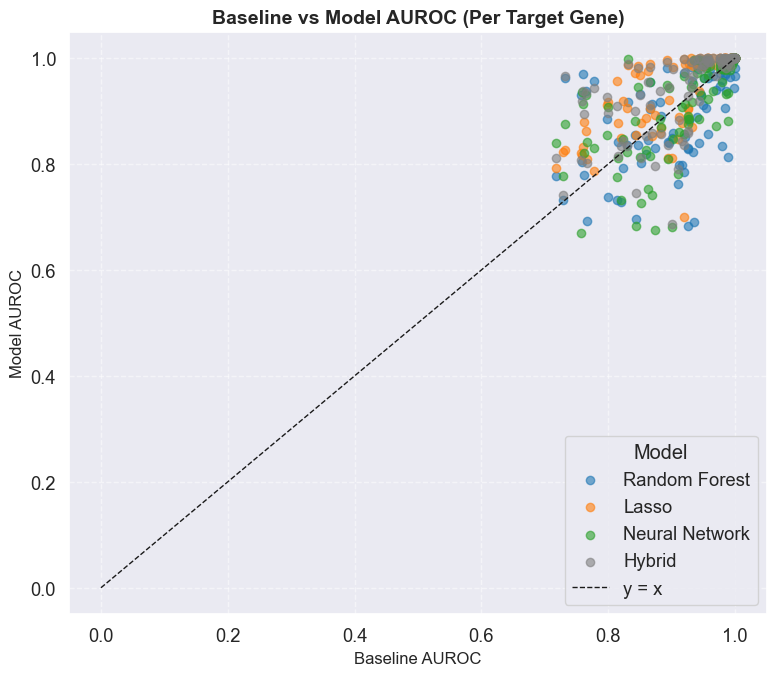

C:\Users\Shera\AppData\Local\Temp\ipykernel_40808\4007343178.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


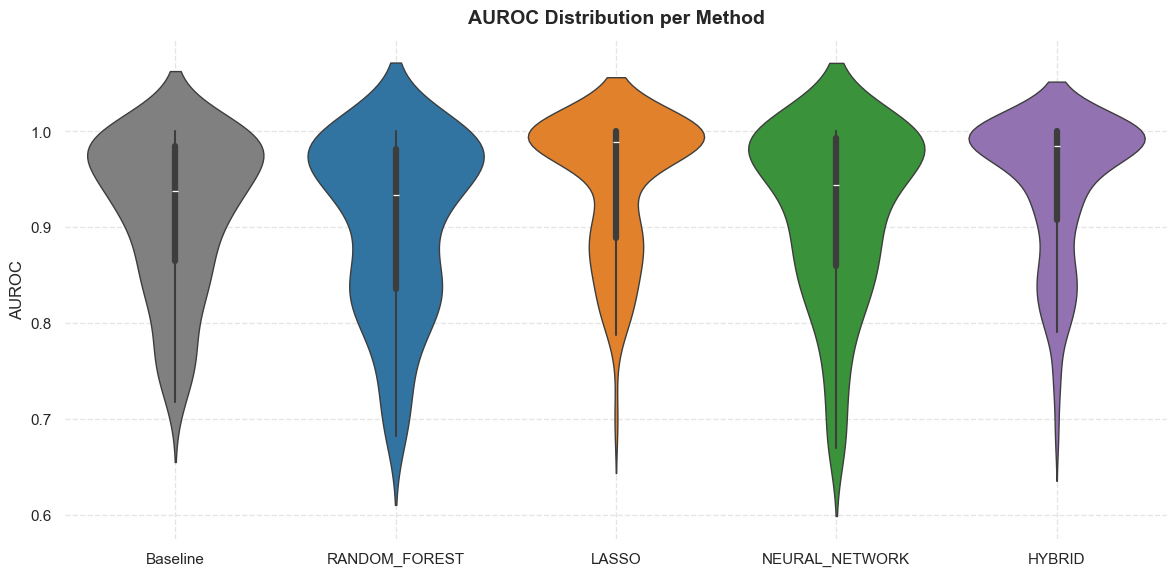


RANDOM_FOREST vs Baseline:
  AUROC   - T: 1.12, P: 2.63e-01, Mean: 0.903
Average AUROC - Baseline: 0.916

LASSO vs Baseline:
  AUROC   - T: -2.80, P: 5.54e-03, Mean: 0.946
Average AUROC - Baseline: 0.916

NEURAL_NETWORK vs Baseline:
  AUROC   - T: 0.13, P: 8.94e-01, Mean: 0.915
Average AUROC - Baseline: 0.916

HYBRID vs Baseline:
  AUROC   - T: -2.44, P: 1.54e-02, Mean: 0.943
Average AUROC - Baseline: 0.916


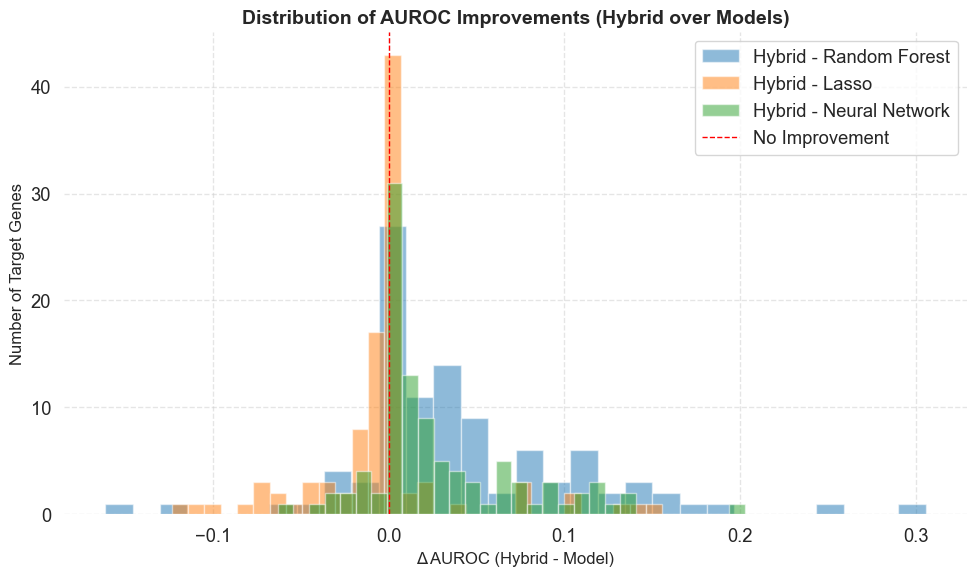

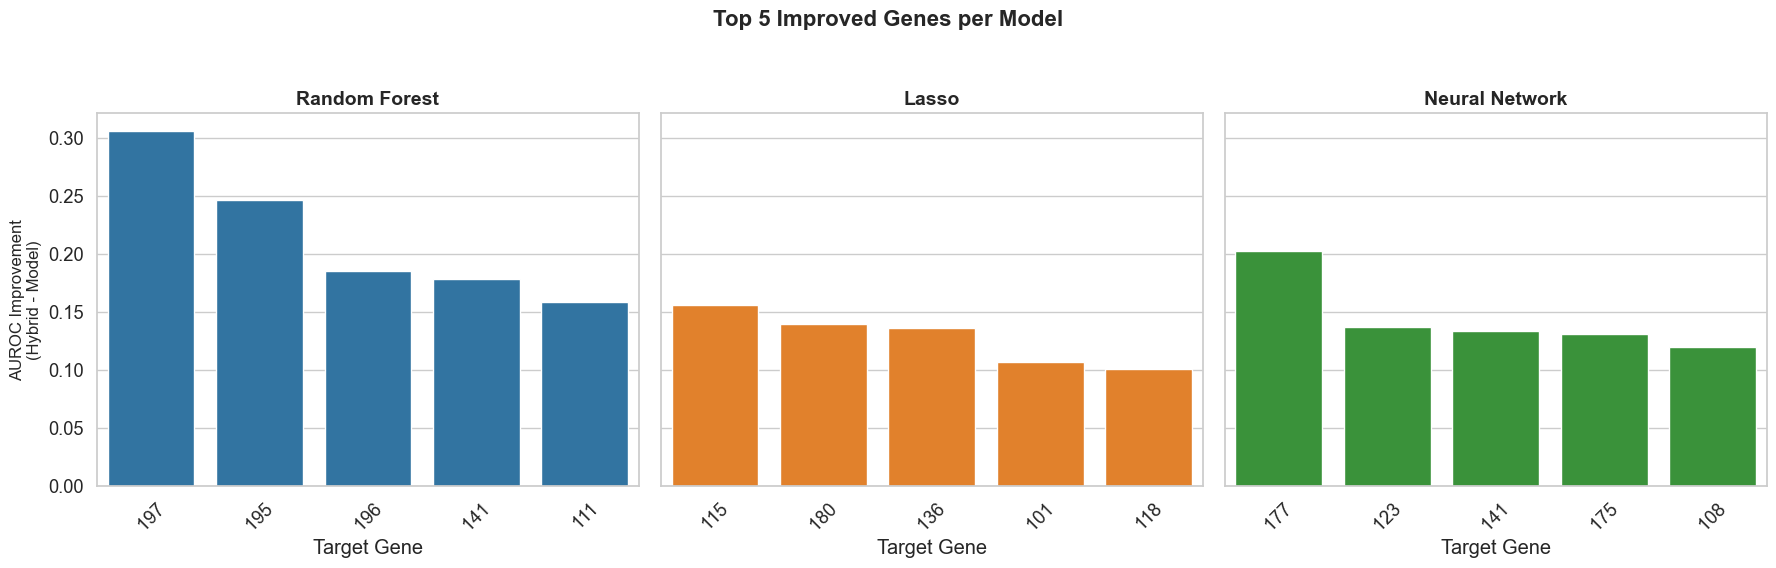

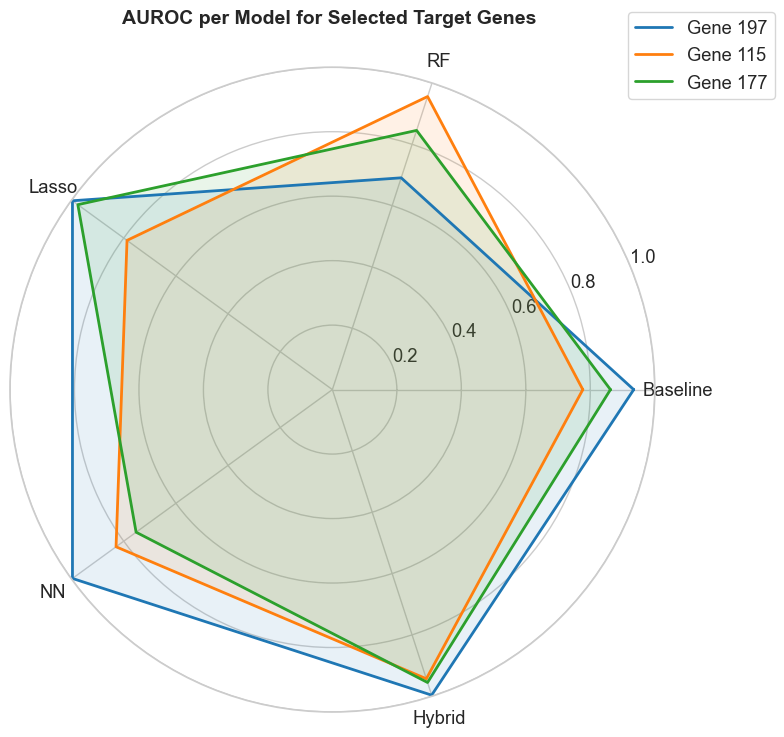

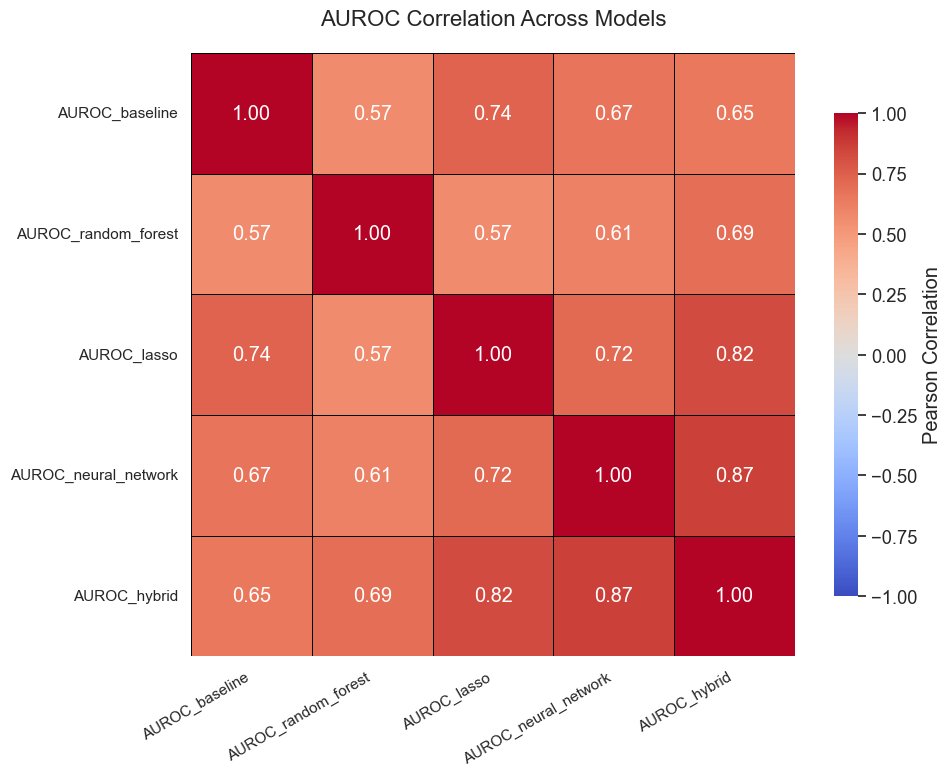

In [5]:
folders = [ "5_mr_50_cond", "40_mr_50_cond", "100_mr_100_cond"]

for folder_name in folders:

    
    filepath = folder_name + "/simulated_noNoise.txt"  
    data = pd.read_csv(filepath, sep="\t")  

   
    if folder_name == "5_mr_50_cond":
        ground_truth_df = pd.read_csv(folder_name + "/bipartite_GRN.csv")
    else:
        ground_truth_df = pd.read_csv(folder_name + "/bipartite_GRN.csv", header=None)
    ground_truth_df.columns = ["TF_id", "Target_gene_id"]
    ground_truth_set = set(tuple(row) for row in ground_truth_df.to_numpy())


    baseline_file = "baseline_use_correlation.xlsx"
    baseline_df = pd.read_excel(baseline_file, sheet_name=folder_name)
    baseline_df.columns = ["TargetGene", "AUROC_baseline"]


    X = data.iloc[:, :100].values   # TFs
    Y = data.iloc[:, 100:].values   # Target Genes


    # results = {
    #     "rf": np.zeros((100, 100)),      
    #     "lasso": np.zeros((100, 100)),
    #     "nn": np.zeros((100, 100))
    # }


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    results = {
        "rf": run_rf(X, Y),
        "lasso": run_lasso(X_scaled, Y),
        "nn": run_nn(X_scaled, Y)
    }

    tf_names = [f"TF_{i}" for i in range(X.shape[1])]
    gene_names = [f"Gene_{i+X.shape[1]}" for i in range(Y.shape[1])]

    hybrid = run_hybrid(results)

    save_model_outputs(results, hybrid, folder_name, tf_names, gene_names)


    model_dfs = [
        (pd.DataFrame(results["rf"], index=gene_names, columns=tf_names), "Random Forest"),
        (pd.DataFrame(results["lasso"], index=gene_names, columns=tf_names), "Lasso"),
        (pd.DataFrame(results["nn"], index=gene_names, columns=tf_names), "Neural Network"),
        (pd.DataFrame(hybrid, index=gene_names, columns=tf_names), "Hybrid"),
    ]

    plot_auroc_curves(model_dfs, ground_truth_set, folder_name)
    plot_pr_curves(model_dfs, ground_truth_set, folder_name)
    merged_df = evaluate_models(model_dfs, ground_truth_set, baseline_df, folder_name)
    plot_all_auroc_deltas(merged_df, folder_name)
    plot_top_gene_improvements_subplots(merged_df, folder_name, top_n=5)
    plot_multi_gene_radar(merged_df, get_top_1_gene_ids(merged_df), folder_name)
    plot_model_correlation_heatmap(merged_df, folder_name)

